# The Battle of Neghborhoods - Part II

---

## Table of Contents

* [Introduction: Business Problem](#intro)
* [Data](#dat)
* [Methodology](#meth)
* [Analysis](#anal)
* [Results: Visualization and Discussion](#res)
* [Conclusion](#conc)

---

## Introduction: Business Problem <a name="intro"></a>

A group of social scientists, the stakeholders of this project, want to answer the following question:

**Does culture influence the kind of venues in a Neighborhood?**

To address this issue, the locations data of three major cities will be used, all three represent different continents and cultures: 

1. **Tokyo** 

 Representing Asia, one of the biggest cities in the continent. 

2. **Barcelona** 

 Representing Europe, a large city in the south of Spain with a differentiated culture. 

3. **New York** 

 More specifically, Queens' area, representing America. 

_Will the different cities be mainly represented by a specific cluster hence their culture highly influences the outcome?_

_Or will the clusters based in the venues be distributed evenly along the three cities? How multicultural and global are these big cities?_

Let's find out!

---

## Data <a name="dat"></a>

For Tokyo, we will get information about the neighborhoods in this [wikidedia link](https://en.wikipedia.org/wiki/Special_wards_of_Tokyo) then we will get the location data via Nominatim module in Geopy. For Barcelona we will use the same method, using this [wikipedia link](https://en.wikipedia.org/wiki/Districts_of_Barcelona). Lastly, for New York we will use the [json file](https://cocl.us/new_york_dataset) used in the labs getting Queens' neighborhoods data and respective locations.

Once we have the location data for the neighborhoods, we will get the venues information through Foursquare. All the data for the neighborhoods of different cities (representing different countries, continents and cultures) will be compiled and clustered. 

### Tokyo location data

In [1]:
import pandas as pd # import pandas library

Get Tokyo districts dataset:

In [2]:
df_tokyo = pd.read_html('https://en.wikipedia.org/wiki/Special_wards_of_Tokyo')[3] # Read html table 
df_tokyo.drop(index = 23, inplace = True) # Drop line with no info
df_tokyo = df_tokyo[['Name', 'Major districts']] # Pick the columns with the useful info
print(df_tokyo.shape) # Dataset shape
df_tokyo.head()

(23, 2)


,Name,Major districts
0,Chiyoda,"Nagatachō, Kasumigaseki, Ōtemachi, Marunouchi,..."
1,Chūō,"Nihonbashi, Kayabachō, Ginza, Tsukiji, Hatchōb..."
2,Minato,"Odaiba, Shinbashi, Hamamatsuchō, Mita, Roppong..."
3,Shinjuku,"Shinjuku, Takadanobaba, Ōkubo, Kagurazaka, Ich..."
4,Bunkyō,"Hongō, Yayoi, Hakusan"


The dataset consists in 23 special wards which one with the descrition of the major neigborhoods.

Transform the data so we get one line for each neighborhood:

In [3]:
neighs = ['District','Neighborhood']
neighs_tokyo = pd.DataFrame(columns = neighs)

for i in range(len(df_tokyo)):
    rowdata = []
    neigh_list = df_tokyo.loc[i, 'Major districts'].split(',')
    district = df_tokyo.loc[i,'Name']
    for neigh in neigh_list:
        rowdata = [district, neigh]
        neighs_tokyo.loc[len(neighs_tokyo)] = rowdata

print('The dataset has ', len(neighs_tokyo), ' lines (neighborhoods).')
neighs_tokyo.head()

The dataset has  106  lines (neighborhoods).


,District,Neighborhood
0,Chiyoda,Nagatachō
1,Chiyoda,Kasumigaseki
2,Chiyoda,Ōtemachi
3,Chiyoda,Marunouchi
4,Chiyoda,Akihabara


In [4]:
from geopy.geocoders import Nominatim # Import Nominatim

Get location data for all entries in Tokyo dataset:

In [5]:
df_coor_tokyo = pd.DataFrame(columns = ['Latitude', 'Longitude'])
for n, d in zip(neighs_tokyo['Neighborhood'], neighs_tokyo['District']):
    address = n + ',' + d
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    coordinates = [latitude, longitude]
    df_coor_tokyo.loc[len(df_coor_tokyo)] = coordinates

In [6]:
df_coor_tokyo.shape # Confirm shape matches with neigh_tokyo

(106, 2)

In [7]:
df_tokyo = neighs_tokyo.join(df_coor_tokyo) # join the 2
print(df_tokyo.shape)
df_tokyo.head()

(106, 4)


,District,Neighborhood,Latitude,Longitude
0,Chiyoda,Nagatachō,35.675618,139.743469
1,Chiyoda,Kasumigaseki,35.674054,139.750972
2,Chiyoda,Ōtemachi,35.686757,139.763616
3,Chiyoda,Marunouchi,35.680656,139.765222
4,Chiyoda,Akihabara,35.699736,139.771250


Remove special characters in the object type values:

In [8]:
import unidecode

In [9]:
df_tokyo['District'] = df_tokyo['District'].apply(unidecode.unidecode) # Change District Column
df_tokyo['Neighborhood'] = df_tokyo['Neighborhood'].apply(unidecode.unidecode) # Change Neighborhood Column
print(df_tokyo.shape)
df_tokyo.head()

(106, 4)


,District,Neighborhood,Latitude,Longitude
0,Chiyoda,Nagatacho,35.675618,139.743469
1,Chiyoda,Kasumigaseki,35.674054,139.750972
2,Chiyoda,Otemachi,35.686757,139.763616
3,Chiyoda,Marunouchi,35.680656,139.765222
4,Chiyoda,Akihabara,35.699736,139.771250


In [10]:
# Get Tokyo coordinates 
address = 'Tokyo'
geolocator = Nominatim(user_agent="foursquare_agent") 
location = geolocator.geocode(address)
tokyo_lat = location.latitude
tokyo_long = location.longitude

Visualize the neighborhoods location with a folium map:

In [11]:
import folium

In [12]:
# define map function

def marker_map(latitude, longitude, df):
    
    marker_map = folium.Map(location=[latitude, longitude], zoom_start=11)  # create map object
    
    # add neighborhoods to map
    for lat, lng, neighborhood, district in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df.iloc[:,1]):
        label = '{}''{}''{}'.format(neighborhood, ' , ', district)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#D6EAF8',
            fill_opacity=0.7,
            parse_html=False).add_to(marker_map) 
    
    return(marker_map)

In [13]:
map_tokyo = marker_map(tokyo_lat, tokyo_long, df_tokyo)
map_tokyo

### Barcelona location data

Get Barcelona districts dataset:

In [14]:
import requests
from bs4 import BeautifulSoup # Import needed libraries

In [15]:
barca_url = 'https://en.wikipedia.org/wiki/Districts_of_Barcelona' # Get data from url
barca_source = requests.get(barca_url).text

In [16]:
barca_soup = BeautifulSoup(barca_source, 'lxml') # Create a beautiful soup entity

In [17]:
barca = barca_soup.find('table', class_ ='wikitable').tbody # Fetch the table

Create the dataset structure:

In [18]:
columns = ['Number', 'District', 'Size', 'Pop','Density', 'Neighborhoods','Councilman','Party']
df_barca = pd.DataFrame(columns = columns)

In [19]:
# Loop to get all table info
for tr_cell in barca.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==8:
        df_barca.loc[len(df_barca)] = row_data

In [20]:
df_barca.head()

,Number,District,Size,Pop,Density,Neighborhoods,Councilman,Party
0,1,Ciutat Vella,4.49,"111,290","24,786","La Barceloneta, El Gòtic, El Raval, Sant Pere,...",Jordi Rabassa i Massons,Barcelona en Comú
1,2,Eixample,7.46,"262,485","35,586","L'Antiga Esquerra de l'Eixample, La Nova Esque...",Jordi Martí Grau,Barcelona en Comú
2,3,Sants-Montjuïc,21.35,"177,636","8,321","La Bordeta, la Font de la Guatlla, Hostafrancs...",Marc Serra Solé,Barcelona en Comú
3,4,Les Corts,6.08,"82,588","13,584","les Corts, la Maternitat i Sant Ramon, Pedralbes",Xavier Marcé Carol,Socialists' Party of Catalonia
4,5,Sarrià-Sant Gervasi,20.09,"140,461","6,992","El Putget i Farró, Sarrià, Sant Gervasi - la B...",Albert Batlle i Bastardas,Socialists' Party of Catalonia


Transform the dataset to match our needs:

In [21]:
neighs = ['District','Neighborhood'] # Select useful columns

# Get one line for each neighborhood

df_neigh = pd.DataFrame(columns = neighs) 
for i in range(len(df_barca)):
    rowdata = []
    neigh_list = df_barca.loc[i, 'Neighborhoods'].split(',')
    district = df_barca.loc[i,'District']
    for neigh in neigh_list:
        rowdata = [district, neigh]
        df_neigh.loc[len(df_neigh)] = rowdata

print(df_neigh.shape) # get new dataset shape
df_neigh.head()

(76, 2)


,District,Neighborhood
0,Ciutat Vella,La Barceloneta
1,Ciutat Vella,El Gòtic
2,Ciutat Vella,El Raval
3,Ciutat Vella,Sant Pere
4,Ciutat Vella,Santa Caterina i la Ribera


Get location data for all entries in Barcelona dataset:

In [22]:
import numpy as np # Import numpy

In [23]:
df_coor_barca = pd.DataFrame(columns = ['Latitude', 'Longitude']) # Define locations dataframe

for n, d in zip(df_neigh['Neighborhood'], df_neigh['District']):
    
    try:
        address = n +','+ d
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        coordinates = [latitude, longitude]
        df_coor_barca.loc[len(df_coor_barca)] = coordinates
    except:
         df_coor_barca.loc[len(df_coor_barca)] = np.nan # Not all lines will return location data

In [24]:
print(df_coor_barca.shape) # See if shape matches df_neigh shape
df_coor_barca.head()

(76, 2)


,Latitude,Longitude
0,41.380653,2.189927
1,41.381505,2.177418
2,41.379518,2.168368
3,41.388322,2.177411
4,41.386650,2.184194


However there is a line without location data:

In [25]:
missing_data = df_coor_barca.isnull() # False when not null, true when null
for column in missing_data.columns.values.tolist(): # Count missing values for each column
    print(column)
    print(missing_data[column].value_counts())
    print("") 

Latitude
False    75
True      1
Name: Latitude, dtype: int64

Longitude
False    75
True      1
Name: Longitude, dtype: int64



Merge the two datasets:

In [26]:
df_barca = df_neigh.join(df_coor_barca)
print(df_barca.shape) # Check shape
df_barca.head()

(76, 4)


,District,Neighborhood,Latitude,Longitude
0,Ciutat Vella,La Barceloneta,41.380653,2.189927
1,Ciutat Vella,El Gòtic,41.381505,2.177418
2,Ciutat Vella,El Raval,41.379518,2.168368
3,Ciutat Vella,Sant Pere,41.388322,2.177411
4,Ciutat Vella,Santa Caterina i la Ribera,41.386650,2.184194


Drop the missing value. Data without location cannot be used.

In [27]:
df_barca.dropna(subset=["Latitude"], axis=0, inplace=True) # Drop lines missing locations values
df_barca.reset_index(drop=True, inplace=True) 
print(df_barca.shape)
df_barca.head()

(75, 4)


,District,Neighborhood,Latitude,Longitude
0,Ciutat Vella,La Barceloneta,41.380653,2.189927
1,Ciutat Vella,El Gòtic,41.381505,2.177418
2,Ciutat Vella,El Raval,41.379518,2.168368
3,Ciutat Vella,Sant Pere,41.388322,2.177411
4,Ciutat Vella,Santa Caterina i la Ribera,41.386650,2.184194


Remove special characters in the object type values:

In [28]:
df_barca['District'] = df_barca['District'].apply(unidecode.unidecode)
df_barca['Neighborhood'] = df_barca['Neighborhood'].apply(unidecode.unidecode)
df_barca.head()

,District,Neighborhood,Latitude,Longitude
0,Ciutat Vella,La Barceloneta,41.380653,2.189927
1,Ciutat Vella,El Gotic,41.381505,2.177418
2,Ciutat Vella,El Raval,41.379518,2.168368
3,Ciutat Vella,Sant Pere,41.388322,2.177411
4,Ciutat Vella,Santa Caterina i la Ribera,41.386650,2.184194


Visualize locations with a folium map:

In [29]:
address = 'Barcelona'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
barca_lat = location.latitude
barca_long = location.longitude

In [30]:
map_barca = marker_map(barca_lat, barca_long, df_barca) # Use defined marker_map function
map_barca

### New York : Queens' Neighboorhoods location data

Get New york districts dataset:

In [31]:
import urllib.request # import library to download the data
url = 'https://cocl.us/new_york_dataset' # Labs dataset
filename = 'newyork_data.json'
urllib.request.urlretrieve(url, filename) # Retrive data 

('newyork_data.json', <http.client.HTTPMessage at 0x1791c973a88>)

In [32]:
import json # import to handle json

In [33]:
with open('newyork_data.json') as json_data: 
    newyork_data = json.load(json_data) # load json data

In [34]:
neighborhoods_data = newyork_data['features']

In [35]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names) # Create dataframe structure

In [36]:
# Load the dataframe with json data

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [37]:
print(neighborhoods.shape)
neighborhoods.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Select Queens Borough for our analysis:

In [38]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
print(queens_data.shape)
queens_data.head()

(81, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Queens,Astoria,40.768509,-73.915654
1,Queens,Woodside,40.746349,-73.901842
2,Queens,Jackson Heights,40.751981,-73.882821
3,Queens,Elmhurst,40.744049,-73.881656
4,Queens,Howard Beach,40.654225,-73.838138


Queens' has a total of 81 neighborhoods.

Visualize location data with a Folium map:

In [39]:
address = 'South Ozone Park , Queens, NY' # will be used as the map center 

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
queens_lat = location.latitude
queens_long = location.longitude

In [40]:
map_queens = marker_map(queens_lat, queens_long, queens_data)
map_queens

Now we have the location data for **106 neighborhoods in Tokyo, 75 in Barcelona and 81 in New York: Queens.**

We can now study the type of venues in these locations.

---

## Methodology <a name="meth"></a>

After gathering the location data of the cities to explore, we will get information about the most common venues for each neighborhood. This will  be done using the Foursquare Api.

In the next step, all the data and information regarding the most common venues for each neighborhood of the studied cities will be compiled in a single dataset, ready for segmenting and clustering.

The clustering step will be done using the **K-means** machine learning algorithm. The data will be segmented in different clusters according to the type of venues of the neighborhoods. The location data will not be used in the clustering process hence the cluster labeling  will not be influenced by the location of the cities.

Lastly, the clusters obtained in the previous step will be associated to the location data of the cities. Then, through data visualization, we will access what is the representation of the clusters in each city. The goal is to evaluate how different the cluster distribution is and with that information answer the question formulated in the business problem:

**Does culture influence the kind of venues in a Neighborhood?**

---

## Analysis <a name="anal"></a>

### Tokyo Venues

Define the variables to call Foursquare API:

In [41]:
CLIENT_ID = 'XXXXXXXX' 
CLIENT_SECRET = 'XXXXXXXX' 
VERSION = '20180605' # Foursquare API version

In [42]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

Define a function that returns the nearby venues for a location through Foursquare:

In [43]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [44]:
# Call function
tokyo_venues = getNearbyVenues(names=df_tokyo['Neighborhood'],
                                   latitudes=df_tokyo['Latitude'],
                                   longitudes=df_tokyo['Longitude']
                                  )

In [45]:
print(tokyo_venues.shape)
tokyo_venues.head()

(7310, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Nagatacho,35.675618,139.743469,Nagatacho Kurosawa (永田町 黒澤),35.674699,139.741737,Japanese Restaurant
1,Nagatacho,35.675618,139.743469,The Capitol Hotel Tokyu (ザ・キャピトルホテル東急),35.673927,139.741019,Hotel
2,Nagatacho,35.675618,139.743469,Tully's Coffee,35.674594,139.743007,Coffee Shop
3,Nagatacho,35.675618,139.743469,Shinamen Hashigo (支那麺 はしご),35.672184,139.741576,Ramen Restaurant
4,Nagatacho,35.675618,139.743469,All Day Dining Origami (オールデイダイニング ORIGAMI),35.673815,139.741104,Restaurant


Now we have a table containing the nearby venues for each Tokyo neighborhood.

One hot encoding for venue category:

In [46]:
# one hot encoding function
def hot_encoding(df):
    
    df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    df_onehot['Neighborhood'] = df['Neighborhood'] 
    return(df_onehot)

In [47]:
tokyo_onehot = hot_encoding(tokyo_venues)

tokyo_onehot.head()

,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nagatacho
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nagatacho
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nagatacho
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nagatacho
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Nagatacho


Group previous table to have the relative frequency of the venues.

In [48]:
tokyo_grouped = tokyo_onehot.groupby('Neighborhood').mean().reset_index()
tokyo_grouped.drop(columns = ['ATM'], inplace = True) # ATM column is not relevant for the study
tokyo_grouped.head()

,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zoo
0,Akihabara,0.0,0.0,0.000000,0.0,0.0,0.04,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.01,0.0,0.0
1,Aobadai,0.0,0.0,0.011765,0.0,0.0,0.00,0.011765,0.011765,0.00000,...,0.0,0.011765,0.011765,0.0,0.011765,0.00000,0.0,0.00,0.0,0.0
2,Aomi,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.02439,...,0.0,0.000000,0.000000,0.0,0.000000,0.02439,0.0,0.00,0.0,0.0
3,Aoto,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00000,...,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.00,0.0,0.0
4,Aoyama,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00000,...,0.0,0.000000,0.016667,0.0,0.000000,0.00000,0.0,0.00,0.0,0.0


In [49]:
# Function to return most common values
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Define a function to create a dataframe containing the most common venues for each neighborhood:

In [50]:
# Function to create a dataframe with sorted most commmon venues

def venues_sorted(num, df_grouped):
    
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    df_venues_sorted = pd.DataFrame(columns=columns)
    df_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

    for ind in np.arange(df_grouped.shape[0]):
        df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

    return(df_venues_sorted)

In [51]:
num_top_venues = 10 # Number of top venues wanted 
tokyo_venues_sorted = venues_sorted(num_top_venues, tokyo_grouped)
tokyo_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akihabara,Hobby Shop,Café,Electronics Store,Ramen Restaurant,Donburi Restaurant,Arcade,Rock Club,Video Game Store,Toy / Game Store,Comic Shop
1,Aobadai,Japanese Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Café,Italian Restaurant,Ramen Restaurant,BBQ Joint,Soba Restaurant,Bar
2,Aomi,Exhibit,Plaza,Convenience Store,Park,Coffee Shop,Sporting Goods Shop,Museum,Clothing Store,Train Station,Chocolate Shop
3,Aoto,Convenience Store,Italian Restaurant,Chinese Restaurant,Mobile Phone Shop,Platform,Intersection,Ramen Restaurant,Sake Bar,Grocery Store,Japanese Restaurant
4,Aoyama,Convenience Store,Coffee Shop,Italian Restaurant,Ramen Restaurant,Soba Restaurant,Japanese Restaurant,Sushi Restaurant,Baseball Stadium,Rock Club,French Restaurant


Now we have table with most common venues for the Tokyo neighborhoods.
We can evaluate the shape of the dataframes:

In [52]:
print(tokyo_venues_sorted.shape)
print(tokyo_grouped.shape)

(106, 11)
(106, 334)


### Barcelona Venues

Now we will repeat the processing of data for Barcelona.

In [53]:
barca_venues = getNearbyVenues(names=df_barca['Neighborhood'],
                                   latitudes=df_barca['Latitude'],
                                   longitudes=df_barca['Longitude']
                                  )

In [54]:
print(barca_venues.shape)
barca_venues.head()

(2908, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,La Barceloneta,41.380653,2.189927,Baluard Barceloneta,41.380047,2.189250,Bakery
1,La Barceloneta,41.380653,2.189927,BRO,41.380214,2.189007,Burger Joint
2,La Barceloneta,41.380653,2.189927,Somorrostro,41.379156,2.189100,Spanish Restaurant
3,La Barceloneta,41.380653,2.189927,La Cova Fumada,41.379254,2.189254,Tapas Restaurant
4,La Barceloneta,41.380653,2.189927,Plaça de la Barceloneta,41.379739,2.188135,Plaza


In [55]:
# one hot encoding using the defined function
barca_onehot = hot_encoding(barca_venues)
barca_onehot.head()

,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
barca_grouped = barca_onehot.groupby('Neighborhood').mean().reset_index()
print(barca_grouped.shape)
barca_grouped.head()

(75, 284)


,Neighborhood,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Bon Pastor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Can Baro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Canyelles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ciutat Meridiana,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Diagonal Mar i el Front Maritim del Poblenou,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
barca_venues_sorted = venues_sorted(num_top_venues, barca_grouped)
barca_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bon Pastor,Grocery Store,Paper / Office Supplies Store,Café,Athletics & Sports,Restaurant,Fabric Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Exhibit
1,Can Baro,Spanish Restaurant,Scenic Lookout,Grocery Store,Dessert Shop,Chinese Restaurant,Basketball Court,Breakfast Spot,Bar,Bakery,Café
2,Canyelles,Hot Spring,Metro Station,Café,Market,Mediterranean Restaurant,Soccer Field,Flea Market,Flower Shop,Fish & Chips Shop,Food Truck
3,Ciutat Meridiana,Metro Station,Train Station,Plaza,Supermarket,Grocery Store,Park,Fabric Shop,Electronics Store,Empanada Restaurant,Ethiopian Restaurant
4,Diagonal Mar i el Front Maritim del Poblenou,Restaurant,Mediterranean Restaurant,Beach Bar,Athletics & Sports,Beach,Spanish Restaurant,Café,Thai Restaurant,Beer Garden,Lounge


In [58]:
print(barca_grouped.shape)
print(barca_venues_sorted.shape)

(75, 284)
(75, 11)


### Queens Venues

At last, we process the data regarding Queens' neighborhoods.

In [59]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

In [60]:
print(queens_venues.shape)
queens_venues.head()

(2058, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915654,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915654,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915654,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
3,Astoria,40.768509,-73.915654,CrossFit Queens,40.769404,-73.918977,Gym
4,Astoria,40.768509,-73.915654,Off The Hook,40.767200,-73.918104,Seafood Restaurant


In [61]:
# one hot encoding
queens_onehot = hot_encoding(queens_venues)
print(queens_onehot.shape)
queens_onehot.head()

(2058, 268)


,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
queens_grouped = queens_onehot.groupby('Neighborhood').mean().reset_index()
print(queens_grouped.shape)
queens_grouped.head()

(81, 268)


,Neighborhood,Accessories Store,Afghan Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Arverne,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.0,0.0,0.0,0.000,0.0,0.058824,0.00,0.0
1,Astoria,0.000,0.0,0.0,0.010204,0.0,0.0,0.0,0.0,0.0,...,0.010204,0.000,0.0,0.0,0.0,0.000,0.0,0.010204,0.00,0.0
2,Astoria Heights,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.0,0.0,0.0,0.000,0.0,0.000000,0.00,0.0
3,Auburndale,0.000,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.0,0.0,0.0,0.000,0.0,0.000000,0.00,0.0
4,Bay Terrace,0.025,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.025,0.0,0.0,0.0,0.025,0.0,0.000000,0.05,0.0


In [63]:
queens_venues_sorted = venues_sorted(num_top_venues, queens_grouped)

queens_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arverne,Surf Spot,Metro Station,Sandwich Place,Thai Restaurant,Coffee Shop,Wine Shop,Beach,Playground,Pizza Place,Bus Stop
1,Astoria,Hookah Bar,Bar,Middle Eastern Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Bakery,Seafood Restaurant,Food & Drink Shop,Food Truck
2,Astoria Heights,Italian Restaurant,Burger Joint,Hostel,Liquor Store,Bakery,Shopping Mall,Supermarket,Bowling Alley,Food,Pizza Place
3,Auburndale,Deli / Bodega,Train,Supermarket,Noodle House,Fast Food Restaurant,Gymnastics Gym,Furniture / Home Store,Korean Restaurant,Pet Store,Toy / Game Store
4,Bay Terrace,Clothing Store,Shoe Store,Kids Store,Mobile Phone Shop,Bus Stop,Women's Store,Lingerie Store,Donut Shop,American Restaurant,Cosmetics Shop


In [64]:
print(queens_grouped.shape)
print(queens_venues_sorted.shape)

(81, 268)
(81, 11)


Now that we have the venue data wrangled for the three cities in study, we can cluster the data.

### Clustering Data with K-means

To have a dataset that embraces all the neighborhoods to cluster we have combine the three datasets in one. Also the neighborhood information must be dropped, we want to cluster data only based in the kind of venues.

In [65]:
# Concatenate data from the 3 cities

grouped_clustering = tokyo_grouped.append(barca_grouped, sort=False)
grouped_clustering = grouped_clustering.append(queens_grouped, sort=False)

grouped_clustering.replace(np.nan, 0, inplace=True) #replace missing values with 0 value

grouped_clustering.reset_index(drop=True, inplace=True) # Reset index

print(grouped_clustering.shape) # Verify if shape = sum of all neighborhoods 
print(106+75+81)

grouped_clustering = grouped_clustering.drop('Neighborhood', 1) # Neighborhood column must not affect clustering

grouped_clustering.head()

(262, 458)
262


,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Souvlaki Shop,State / Provincial Park,Strip Club,Summer Camp,Supplement Shop,Tailor Shop,Tibetan Restaurant,Train,Warehouse Store,Weight Loss Center
0,0.0,0.0,0.000000,0.0,0.0,0.04,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.011765,0.0,0.0,0.00,0.011765,0.011765,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.02439,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will cluster the data using the K-Means algorithm:

In [66]:
from sklearn.cluster import KMeans

The data will be segmented into 10 different clusters:

In [67]:
kclusters = 10

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
k_labels = kmeans.labels_
print(k_labels.size)
k_labels

262


array([2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 2, 8, 2, 2, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       2, 1, 1, 2, 1, 1, 8, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2,
       8, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 5, 0, 5, 8,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 8, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 7, 8, 5, 1, 5, 5,
       7, 5, 5, 8, 5, 5, 5, 5, 5, 0, 7, 5, 5, 0, 5, 5, 5, 7, 8, 5, 5, 5,
       5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 3, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7,
       7, 7, 7, 7, 8, 7, 7, 7, 5, 7, 7, 7, 2, 4, 7, 7, 7, 7, 7, 7, 5, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 9, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7])

Then we concatenate the data with the most common venues and insert the clusters label for analysis:

In [68]:
# Concatenate data from the 3 cities

total_venues_sorted = tokyo_venues_sorted.append(barca_venues_sorted, sort=False)
total_venues_sorted = total_venues_sorted.append(queens_venues_sorted, sort=False)

total_venues_sorted.reset_index(drop=True, inplace=True) 
total_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_) # insert column with cluster labels
print(total_venues_sorted.shape)
print(106+75+81)
total_venues_sorted.head()

(262, 12)
262


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Akihabara,Hobby Shop,Café,Electronics Store,Ramen Restaurant,Donburi Restaurant,Arcade,Rock Club,Video Game Store,Toy / Game Store,Comic Shop
1,2,Aobadai,Japanese Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Café,Italian Restaurant,Ramen Restaurant,BBQ Joint,Soba Restaurant,Bar
2,2,Aomi,Exhibit,Plaza,Convenience Store,Park,Coffee Shop,Sporting Goods Shop,Museum,Clothing Store,Train Station,Chocolate Shop
3,1,Aoto,Convenience Store,Italian Restaurant,Chinese Restaurant,Mobile Phone Shop,Platform,Intersection,Ramen Restaurant,Sake Bar,Grocery Store,Japanese Restaurant
4,2,Aoyama,Convenience Store,Coffee Shop,Italian Restaurant,Ramen Restaurant,Soba Restaurant,Japanese Restaurant,Sushi Restaurant,Baseball Stadium,Rock Club,French Restaurant


---

## Results: Visualization and Discussion <a name="res"></a>

Once the data is clustered and labeled we can visualize the cluster distribution and discuss the results obtained.

### Tokyo

We need to add location information to the venues dataframe:

In [69]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tokyo_merged = pd.merge(df_tokyo, total_venues_sorted, how='inner', on=['Neighborhood'])
print(tokyo_merged.shape)
pd.set_option('display.max_rows', None)
tokyo_merged.head()

(106, 15)


,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chiyoda,Nagatacho,35.675618,139.743469,1,Convenience Store,Coffee Shop,Japanese Restaurant,Hotel,Ramen Restaurant,Intersection,Bike Rental / Bike Share,Trail,Chinese Restaurant,Pizza Place
1,Chiyoda,Kasumigaseki,35.674054,139.750972,1,Convenience Store,Coffee Shop,Historic Site,Concert Hall,Restaurant,Café,Chinese Restaurant,Intersection,Ramen Restaurant,Lawyer
2,Chiyoda,Otemachi,35.686757,139.763616,2,Coffee Shop,Japanese Restaurant,Café,Hotel,Italian Restaurant,Lounge,Convenience Store,Sake Bar,Historic Site,Chinese Restaurant
3,Chiyoda,Marunouchi,35.680656,139.765222,2,Café,Japanese Restaurant,Hotel,Sushi Restaurant,Coffee Shop,Train Station,Deli / Bodega,French Restaurant,Ramen Restaurant,Lounge
4,Chiyoda,Akihabara,35.699736,139.771250,2,Hobby Shop,Café,Electronics Store,Ramen Restaurant,Donburi Restaurant,Arcade,Rock Club,Video Game Store,Toy / Game Store,Comic Shop


Set a color code for each cluster:

In [70]:
# Colors scheme for all the maps 
colors = ['#BA4A00','#AF7AC5','#2980B9','#45B39D', '#F4D03F','#47F219','#F39C12','#E74C3C','#2C3E50','#F53991']

In [71]:
# Define function to map locations with cluster color code

def clusters_map(latitude, longitude, df):

    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'],df['Neighborhood'], df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colors[cluster],
            fill=True,
            fill_color=colors[cluster],
            fill_opacity=0.7).add_to(map_clusters)
        
    return(map_clusters)

In [72]:
tokyo_map_clusters = clusters_map(tokyo_lat, tokyo_long, tokyo_merged)
tokyo_map_clusters

Analysing the map. We can see that most of the neighborhoods in **Tokyo** are into **Cluster 1 (Purple spots)** and **Cluster 2 (Blue spots)**.

### Barcelona

Repeat the process for Barcelona neighborhoods:

In [73]:
barca_merged = pd.merge(df_barca, total_venues_sorted, how='inner', on=['Neighborhood'])
print(barca_merged.shape)
barca_merged.head()

(75, 15)


,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciutat Vella,La Barceloneta,41.380653,2.189927,5,Tapas Restaurant,Bar,Paella Restaurant,Mediterranean Restaurant,Spanish Restaurant,Restaurant,Pizza Place,Burger Joint,Plaza,Ice Cream Shop
1,Ciutat Vella,El Gotic,41.381505,2.177418,5,Tapas Restaurant,Ice Cream Shop,Italian Restaurant,Spanish Restaurant,Plaza,Coffee Shop,Hotel,Bar,Cocktail Bar,Mediterranean Restaurant
2,Ciutat Vella,El Raval,41.379518,2.168368,5,Cocktail Bar,Spanish Restaurant,Mediterranean Restaurant,Tapas Restaurant,Bookstore,Pizza Place,Bar,Beer Bar,Hotel,Restaurant
3,Ciutat Vella,Sant Pere,41.388322,2.177411,5,Hotel,Tapas Restaurant,Japanese Restaurant,Ice Cream Shop,Bistro,Breakfast Spot,Accessories Store,Coffee Shop,Restaurant,Mediterranean Restaurant
4,Ciutat Vella,Santa Caterina i la Ribera,41.386650,2.184194,5,Tapas Restaurant,Breakfast Spot,Camera Store,Cocktail Bar,Mediterranean Restaurant,Diner,Shoe Store,Burger Joint,Café,Restaurant


In [74]:
barca_map_clusters = clusters_map(barca_lat, barca_long, barca_merged)
barca_map_clusters

Analysing the map. We can see that most of the neighborhoods in **Barcelona** are into **Cluster 5 (Green spots)**.

### Queens

Repeat the process for Queens:

In [75]:
queens_merged = pd.merge(queens_data, total_venues_sorted, how='inner', on=['Neighborhood'])
print(queens_merged.shape)
queens_merged.head()

(81, 15)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Queens,Astoria,40.768509,-73.915654,7,Hookah Bar,Bar,Middle Eastern Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Bakery,Seafood Restaurant,Food & Drink Shop,Food Truck
1,Queens,Woodside,40.746349,-73.901842,7,Grocery Store,Thai Restaurant,Filipino Restaurant,Latin American Restaurant,Bakery,Donut Shop,American Restaurant,Bar,Pizza Place,Pub
2,Queens,Jackson Heights,40.751981,-73.882821,7,Latin American Restaurant,Peruvian Restaurant,South American Restaurant,Bakery,Mexican Restaurant,Grocery Store,Mobile Phone Shop,Thai Restaurant,Spanish Restaurant,Empanada Restaurant
3,Queens,Elmhurst,40.744049,-73.881656,7,Thai Restaurant,Mexican Restaurant,South American Restaurant,Vietnamese Restaurant,Colombian Restaurant,Snack Place,Sushi Restaurant,Malay Restaurant,Chinese Restaurant,Bar
4,Queens,Howard Beach,40.654225,-73.838138,7,Italian Restaurant,Pharmacy,Clothing Store,Fast Food Restaurant,Sandwich Place,Bagel Shop,Chinese Restaurant,Bank,Tapas Restaurant,Sushi Restaurant


In [76]:
queens_map_clusters = clusters_map(queens_lat, queens_long, queens_merged)
queens_map_clusters

Analysing the map. We can see that most of the neighborhoods in **Queens** are into **Cluster 7 (Red spots)**.

### Cluster distribuition

We can access neighborhood distribution for each city in an aggregated way. First we insert one column with the city name to the dataset containing the venues and cluster information.

In [77]:
# Create a column to label each city
city = []
stop1 = 106
stop2 = 106 + 75
stop3 = len(total_venues_sorted)
for i in range(stop1):
    city.append('Tokyo')
for i in range(stop1,stop2):
    city.append('Barcelona')
for i in range(stop2,stop3):
    city.append('Queens')

In [79]:
cities_sorted = total_venues_sorted.iloc[:]
cities_sorted.insert(0, 'City', city)
cities_sorted.head()

,City,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Tokyo,2,Akihabara,Hobby Shop,Café,Electronics Store,Ramen Restaurant,Donburi Restaurant,Arcade,Rock Club,Video Game Store,Toy / Game Store,Comic Shop
1,Tokyo,2,Aobadai,Japanese Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Café,Italian Restaurant,Ramen Restaurant,BBQ Joint,Soba Restaurant,Bar
2,Tokyo,2,Aomi,Exhibit,Plaza,Convenience Store,Park,Coffee Shop,Sporting Goods Shop,Museum,Clothing Store,Train Station,Chocolate Shop
3,Tokyo,1,Aoto,Convenience Store,Italian Restaurant,Chinese Restaurant,Mobile Phone Shop,Platform,Intersection,Ramen Restaurant,Sake Bar,Grocery Store,Japanese Restaurant
4,Tokyo,2,Aoyama,Convenience Store,Coffee Shop,Italian Restaurant,Ramen Restaurant,Soba Restaurant,Japanese Restaurant,Sushi Restaurant,Baseball Stadium,Rock Club,French Restaurant


Get the number of neighborhoods by cluster and city:

In [80]:
cities_sorted = cities_sorted[['City','Cluster Labels','Neighborhood']]
cities_sorted = cities_sorted.groupby(['City','Cluster Labels'], as_index=False).count()

Transform the data into a pivot table for better interpretation: 

In [81]:
cities_pivot = cities_sorted.pivot(index='City',columns='Cluster Labels', values ='Neighborhood')
cities_pivot

Cluster Labels,0,1,2,3,4,5,6,7,8,9
City,,,,,,,,,,
Barcelona,5.0,1.0,NaN,NaN,NaN,60.0,NaN,4.0,5.0,NaN
Queens,NaN,NaN,2.0,1.0,1.0,2.0,1.0,71.0,2.0,1.0
Tokyo,NaN,34.0,69.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN


In [82]:
cities_pivot = cities_pivot.fillna(0) # Replace null values with 0

In [83]:
cities_pivot.columns.name = None # Tranform the pivot for plotting
cities_pivot.index.name = None
cities_pivot = cities_pivot.astype('int')
cities_pivot

,0,1,2,3,4,5,6,7,8,9
Barcelona,5,1,0,0,0,60,0,4,5,0
Queens,0,0,2,1,1,2,1,71,2,1
Tokyo,0,34,69,0,0,0,0,0,3,0


In [84]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

Using the pivot table we can plot the number of neighborhoods in each cluster by city  using matplotlib:

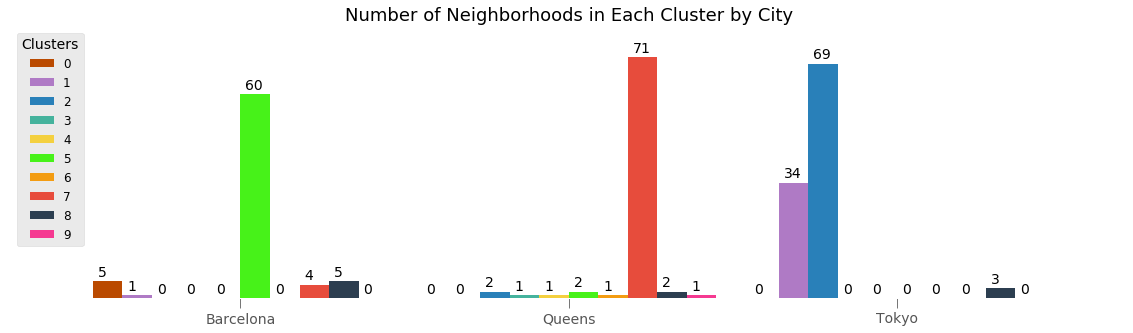

In [85]:
ax = cities_pivot.plot(kind='bar', width  = 0.9, figsize=(20, 5), color = colors)
ax.set_title('Number of Neighborhoods in Each Cluster by City', fontsize = 18)
ax.legend(fontsize=12 , title = 'Clusters', title_fontsize = 14, loc =2 )
ax.yaxis.set_visible(False)
ax.set_ylim(0,80)
ax.xaxis.set_tick_params(labelsize=14, labelrotation = 0, direction='out', length=10)
ax.patch.set_facecolor('white')
for i in ax.patches:
    ax.text(i.get_x()+.015, i.get_height()+1.5, str(i.get_height()), fontsize=14)

Intertpreting the plot we can see that **Barcelona**'s neighborhoods are mostly inside **Cluster 5 (60 neighborhoods)** . 

**New York, represented by Queens** is the city with most varied clusters. Still **Cluster 7 (71 neighborhoods)** is the most frequent.

**Tokyo** has high representation in **Clusters 1 and 2 (34 and 69 neighborhoods respectively)**. Cluster 1 is the most frequent.

### Analyze main clusters for each city

#### Tokyo: Clusters 1 and 2

In [86]:
Cluster1 = total_venues_sorted[total_venues_sorted['Cluster Labels']==1]
Cluster1 = Cluster1.loc[:,'1st Most Common Venue':'10th Most Common Venue']
Cluster1.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Convenience Store,Italian Restaurant,Chinese Restaurant,Mobile Phone Shop,Platform,Intersection,Ramen Restaurant,Sake Bar,Grocery Store,Japanese Restaurant
5,Convenience Store,Coffee Shop,Italian Restaurant,Intersection,Café,Bus Stop,Plaza,Bike Rental / Bike Share,Hotel,Chinese Restaurant
16,Convenience Store,Ramen Restaurant,BBQ Joint,Japanese Restaurant,Dessert Shop,Chinese Restaurant,Donburi Restaurant,Sake Bar,Grocery Store,Supermarket
18,Convenience Store,Café,Japanese Restaurant,Hotel,Ramen Restaurant,Sake Bar,Chinese Restaurant,Park,Platform,Boat or Ferry
20,Convenience Store,Coffee Shop,Sushi Restaurant,Grocery Store,Noodle House,Train Station,Drugstore,Donburi Restaurant,Udon Restaurant,Japanese Restaurant


In [88]:
Cluster1.describe(include=['object'])

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,35,35,35,35,35,35,35,35,35,35
unique,3,11,17,27,22,23,28,28,25,26
top,Convenience Store,Ramen Restaurant,Japanese Restaurant,Intersection,Donburi Restaurant,Bus Stop,Chinese Restaurant,Sake Bar,Chinese Restaurant,Supermarket
freq,31,9,7,3,3,4,3,3,4,3


You can see that cluster 1 has a lot of **Convenience Stores, Ramen and Japanese Restaurants**, indicating great culture influence. Another example, **Sake Bar** is the 8th most common type  of venue  in this cluster.

In [89]:
Cluster2 = total_venues_sorted[total_venues_sorted['Cluster Labels']==2]
Cluster2 = Cluster2.loc[:,'1st Most Common Venue':'10th Most Common Venue']
Cluster2.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hobby Shop,Café,Electronics Store,Ramen Restaurant,Donburi Restaurant,Arcade,Rock Club,Video Game Store,Toy / Game Store,Comic Shop
1,Japanese Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Café,Italian Restaurant,Ramen Restaurant,BBQ Joint,Soba Restaurant,Bar
2,Exhibit,Plaza,Convenience Store,Park,Coffee Shop,Sporting Goods Shop,Museum,Clothing Store,Train Station,Chocolate Shop
4,Convenience Store,Coffee Shop,Italian Restaurant,Ramen Restaurant,Soba Restaurant,Japanese Restaurant,Sushi Restaurant,Baseball Stadium,Rock Club,French Restaurant
6,Japanese Restaurant,Italian Restaurant,Sake Bar,Café,BBQ Joint,Wagashi Place,Takoyaki Place,Chinese Restaurant,Convenience Store,Thai Restaurant


In [90]:
Cluster2.describe(include=['object'])

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,71,71,71,71,71,71,71,71,71,71
unique,20,15,29,28,31,39,45,47,45,50
top,Japanese Restaurant,Japanese Restaurant,Convenience Store,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Hotel,BBQ Joint,Chinese Restaurant,Chinese Restaurant
freq,16,14,10,9,7,7,5,7,5,4


Cluster 2 is dominated by **Japanese Restaurants**. Also there is a lot of **Chinese Restaurants** in this areas. Once again, culture plays a pivotal role in this outcome.

#### Barcelona: Cluster 5

In [91]:
Cluster5 = total_venues_sorted[total_venues_sorted['Cluster Labels']==5]
Cluster5 = Cluster5.loc[:,'1st Most Common Venue':'10th Most Common Venue']
Cluster5.head()
Cluster5.describe(include=['object'])

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,62,62,62,62,62,62,62,62,62,62
unique,24,26,35,30,35,37,39,43,45,42
top,Tapas Restaurant,Hotel,Mediterranean Restaurant,Spanish Restaurant,Spanish Restaurant,Restaurant,Café,Supermarket,Tapas Restaurant,Supermarket
freq,9,6,8,6,5,4,4,5,3,4


In Cluster 5, culture has a high impact in the cluster with a lot of **Tapas, Meditterranean and Spanish Restaurants**. 

**Hotel** is the 2nd most common venue for the majority of neighborhoods, this is explained by the high level of tourism in Barcelona.

#### Queens: Cluster 7

In [92]:
Cluster7 = total_venues_sorted[total_venues_sorted['Cluster Labels']==7]
Cluster7 = Cluster7.loc[:,'1st Most Common Venue':'10th Most Common Venue']
Cluster7.head()
Cluster7.describe(include=['object'])

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,75,75,75,75,75,75,75,75,75,75
unique,43,46,52,49,46,51,53,55,52,56
top,Deli / Bodega,Pizza Place,Deli / Bodega,Donut Shop,Pizza Place,Fast Food Restaurant,Donut Shop,Fast Food Restaurant,Bakery,Sandwich Place
freq,9,6,4,5,9,4,4,4,4,4


Cluster 7 is characterized by the **Deli /Bodega** venues (kind of convenience store), **Pizza, Fast Food and Donut Shops** show the culture influence in the type of venues.

---

## Conclusion <a name="conc"></a>

The purpose of this project was to access the culture impact in the type of venues. After segmenting the information on the venues of neighborhoods in each city we can conclude that culture influences venues.

The data was segmented in 10 distinct clusters using the K-Means algorithm. Each of the cities had shown a trend of specific clusters that had some common features. New York (Queens in particular) where the city with the most varied set of clusters, with neighborhoods placed within a range of 8 distinct clusters.  

Cities were structered as follows:  

* **Tokyo** - Tokyo neighborhoods were mainly into Clusters 1 and 2 in which among the most common venues are Oriental Restaurants, Convenience Stores and Sake Bars. 

* **Barcelona** - Barcelona neighborhoods were mainly into Cluster 5 in which among the most common venues were Tapas Restaurants (typical south spanish restaurants), Mediterranean and Spanish Restaurants.

* **New York: Queens** - Queens neighborhoods were mainly into Cluster 7 in which among the most common venues were Deli / Bodegas (typical New York stores), Pizza Places and Fast Food.

Attending this information, we can answer the question formulated in the Business Problem: **Culture has a high influence in the kind of venues in the cities.**

---